# 偏差和方差

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'],d['y'],d['Xval'],d['yval'],d['Xtest'],d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

d:\Program Files\Python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
d:\Program Files\Python\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


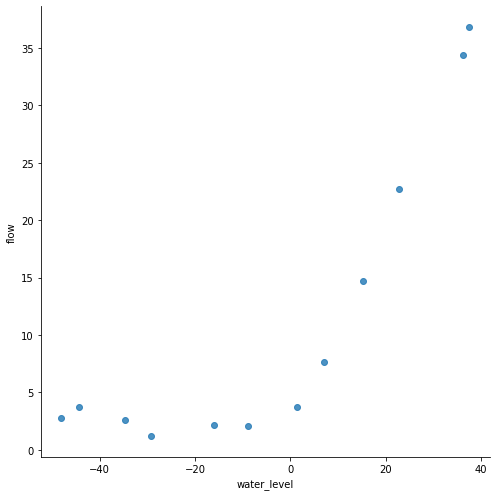

In [4]:
df = pd.DataFrame({'water_level':X, 'flow':y})
sns.lmplot('water_level','flow',data=df,fit_reg=False,size=7)
plt.show()

In [5]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

# 代价函数

In [6]:
def CostFunction(theta, X, y):
    m = X.shape[0]
    inner = X @ theta - y
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    return cost

In [7]:
theta = np.ones(X.shape[1])
CostFunction(theta, X, y)

303.9515255535976

# 正则化代价函数

In [8]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = (1 / (2*m)) * np.power(theta[1:],2).sum()
    return CostFunction(theta, X, y) + regularized_term

# 梯度

In [9]:
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)
    return inner / m

In [10]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度

In [11]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = theta.copy()
    regularized_term[0] = 0
    regularized_term = (l / m) * regularized_term
    return gradient(theta, X, y) + regularized_term

In [12]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据

In [13]:
def trainLinearReg(X, y, l=1):
    # init theta
    theta = np.ones(X.shape[1])
    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [14]:
theta = np.ones(X.shape[0])
final_theta = trainLinearReg(X,y,l=0).get('x')
final_theta

array([13.08790362,  0.36777923])

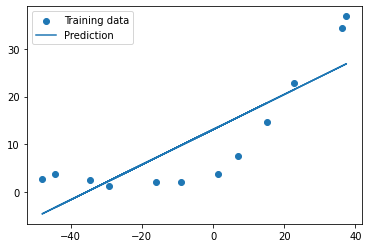

In [15]:
b = final_theta[0] # intercept
m = final_theta[1] # slope
plt.scatter(X[:,1], y, label='Training data')
plt.plot(X[:,1],X[:,1]*m+b,label='Prediction')
plt.legend(loc=2)
plt.show()

In [16]:
training_cost, cv_cost = [],[] 

In [17]:
m = X.shape[0]
for i in range(1, m+1):
    res = trainLinearReg(X[:i,:],y[:i],l=0)
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    training_cost.append(tc)
    cv_cost.append(cv)

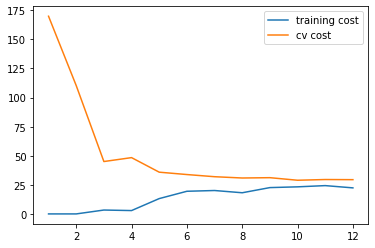

In [18]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

# 创建多项式特征

In [19]:
def poly_features(x, power, as_ndarray=False):
    data = {f'f{i}':np.power(x,i) for i in range(1, power+1)}
    df = pd.DataFrame(data)
    return df.as_matrix() if as_ndarray else df

In [20]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [21]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [22]:
def prepare_poly_data(*args, power):
    def prepare(x):
        df = poly_features(x, power=power)
        ndarr = normalize_feature(df).values
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    return [prepare(x) for x in args]

# 准备多项式回归数据

In [23]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [24]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 绘制学习曲线

In [25]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        res = trainLinearReg(X[:i, :], y[:i], l=l)

        tc = CostFunction(res.x, X[:i, :], y[:i])
        cv = CostFunction(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

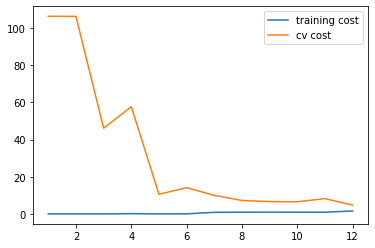

In [26]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

# try $\lambda=1$

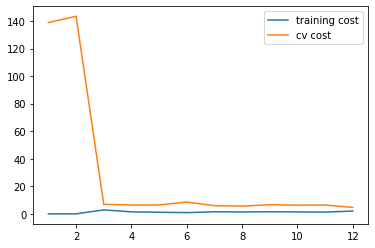

In [27]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

# try $\lambda=100$

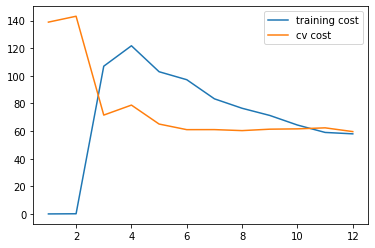

In [28]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

# 找到最佳的 $\lambda$

In [29]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [30]:
for l in l_candidate:
    res = trainLinearReg(X_poly, y, l)
    
    tc = CostFunction(res.x, X_poly, y)
    cv = CostFunction(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

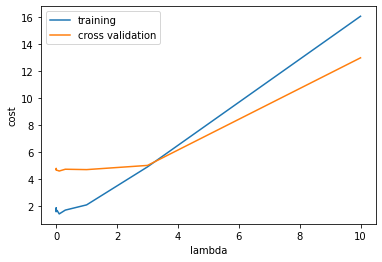

In [32]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()